In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
from matplotlib import patheffects

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

from netCDF4 import Dataset

from datetime import datetime
from glob import glob
from matplotlib import patheffects
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker

import xarray as xr
from pathlib import Path
import os

import cftime

import ipywidgets as widgets

import matplotlib.ticker as ticker

import imageio

import ipywidgets as widgets
from IPython.display import display, Video
from PIL import Image
import re


In [5]:
def has_time(da, time_val):
    return any(t == time_val for t in da['time'].values)

In [6]:
def get_scientific_multiplier(value):
    if value == 0:
        return "e0"  # Special case: log10(0) is undefined
    sci_str = "{:e}".format(value)  # E.g., '1.000000e+04'
    _, exponent = sci_str.split('e')
    return f"e{int(exponent)}"

# Examples
print(get_scientific_multiplier(0.001))     # e-3
print(get_scientific_multiplier(10000))     # e4
print(get_scientific_multiplier(5.67e-7))   # e-7
print(f"1{get_scientific_multiplier(1234567)}") # e6


e-3
e4
e-7
1e6


In [7]:
def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

In [8]:
def convert_int_to_time_units(date_int: int, unit: str = "days") -> str:
    """
    Converts an integer date (YYYYMMDD) to a time units string.
    
     
    Args:
    date_int: The integer date in YYYYMMDD format (e.g., 20171219).unit: The time unit to use (e.g., "days", "hours", "seconds").Defaults to "days".
    Returns:A string formatted for xarray time coordinate units(e.g., "days since 2017-12-19")."""
    # Convert the integer to a string
    date_str = str(date_int)
    # Extract year, month, and day
    year = int(date_str[0:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])
    timestamp = pd.Timestamp(year=year, month=month, day=day)
    time_units_str = f"{unit} since {timestamp.strftime('%Y-%m-%d')}"
    return time_units_str, timestamp


In [9]:

# Number of segments
n_brown = 128
n_white = 16
n_grey = 128

# Get brown tones from BrBG (first half)
brbg = plt.get_cmap('BrBG')
browns = brbg(np.linspace(0, 0.5, n_brown))

# Get grey tones from RdGy (second half)
rdgy = plt.get_cmap('RdGy')
greys = rdgy(np.linspace(0.5, 1, n_grey))

# Create white strip
white = np.ones((n_white, 4))  # RGBA

# Combine all into one array
colors = np.vstack([browns, white, greys])
BrGy = ListedColormap(colors, name='BrGy')

# Optional: Register with matplotlib
plt.register_cmap(name='BrGy', cmap=BrGy)





# Create reversed version by flipping the colors array
BrGy_r = ListedColormap(colors[::-1], name='BrGy_r')

# Register the reversed colormap
plt.register_cmap(name='BrGy_r', cmap=BrGy_r)

/glade/derecho/scratch/richling/tmp/ipykernel_60659/2941034556.py:22: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='BrGy', cmap=BrGy)
/glade/derecho/scratch/richling/tmp/ipykernel_60659/2941034556.py:32: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='BrGy_r', cmap=BrGy_r)


In [10]:
# --- Settings dropdowns ---
def load_and_search_user_nl(file_path,search_var):
    lines = []
    lines_all = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith(f' {search_var}'):
                    lines.append(line.strip())
                if line.startswith(' '):
                    lines_all.append(line.strip())
    except Exception as e:
        lines = [f"Error reading user_nl_cam: {e}"]
        lines_all = lines
    return "\n".join(lines), "\n".join(lines_all)

In [13]:
case_name = "F2000climo.f09_f09_mg17.window.exp.6hrInit.R13.003"

In [14]:
Hwin_latlonWidth = "Specify the lat and lon widths of the horizontal window in degrees. Setting a width to a large value (e.g. 999.) renders the window constant in that direction."
Hwin_latlonDelta = "Specify the sharpness of the window transition with a length in degrees. Small values yield a step function while larger give a smoother transition."
Vwin_Lindex = "In the vertical, the window is specified in terms of model indices. These specify the High (model bottom) and Low (model top) transition levels. (For constant vertical window, set Lindex=0 and Hindex=NLEV+1)  [0., (NLEV-1)]"
Vwin_Hindex = "In the vertical, the window is specified in terms of model indices. These specify the High (model bottom) and Low (model top) transition levels. (For constant vertical window, set Lindex=0 and Hindex=NLEV+1)  [2., (NLEV+1)]"
Vwin_LHdelta = "The transition lengths are specified in terms of model level indices. (For a constant vertical window, set the transition lengths to 0.001)"
Hwin_lat0 = ""
Hwin_lon0 = ""
prof = "Selectively apply nudging to [U,V,T,Q]:\n0 (OFF) = Switch off nudging\n1 (ON) = Apply nudging everywhere\n2 (WINDOW) = Apply window function to nudging tendencies.  [0.,1.]"
coef = "Selectively adjust the nudging strength applied to [U,V,T,Q]. (normalized)  [0.,1.]"
Hwin_latlonDelta = "Specify the sharpness of the window transition with a length in degrees. Small values yield a step function while larger give a smoother transition."

In [15]:
def slider(case_name, image_dir=f"plots/{case_name}/MERRA_T_minus_T/",lev=None):
    tooltip_dict = {
        "Nudge_Uprof": prof,
        "Nudge_Ucoef": coef,
        "Nudge_Hwin_lat0": Hwin_lat0,
        "Nudge_Hwin_lon0": Hwin_lon0,
        "Nudge_Hwin_latWidth": Hwin_latlonWidth,
        "Nudge_Hwin_lonWidth": Hwin_latlonWidth,
        "Nudge_Vwin_Hindex": Vwin_Hindex,
        "Nudge_Vwin_Lindex": Vwin_Lindex,
        "Nudge_Vwin_Hdelta": Vwin_LHdelta,
        "Nudge_Vwin_Ldelta": Vwin_LHdelta,
        "Nudge_Hwin_latDelta": Hwin_latlonDelta,
        "Nudge_Hwin_lonDelta": Hwin_latlonDelta,
    }
    
    link_dict = {
        "Nudge_Uprof": "https://ncar.github.io/CAM/doc/build/html/users_guide/physics-modifications-via-the-namelist.html?highlight=nudge#namelist-values",
        #"Nudge_U": "https://example.com/nudge_u"
    }
    
    
    import os
    from PIL import Image
    from io import BytesIO
    import base64
    from IPython.display import display, HTML
    import ipywidgets as widgets
    
    # --- Settings ---
    #case_name = "nudged-socrates-exp-001-window"
    #image_dir = f"plots/{case_name}/MERRA_T_minus_T/"
    
    # --- Load images and timestamps ---
    image_files = sorted([
        os.path.join(image_dir, f) for f in os.listdir(image_dir)
        if f.endswith(f'{lev}hPa.png')
    ])
    
    timestamps = ['-'.join(os.path.basename(f).split('_')[0:3]) + ' ' + os.path.basename(f).split('_')[3] for f in image_files]
    
    # --- Convert image to HTML for display ---
    def image_to_html(path):
        img = Image.open(path).resize((1000, 300))
        buffer = BytesIO()
        img.save(buffer, format='PNG')
        b64 = base64.b64encode(buffer.getvalue()).decode()
        return f"<img src='data:image/png;base64,{b64}' style='width:100%;'/>"
    
    # --- Create widgets ---
    slider = widgets.IntSlider(min=0, max=len(image_files)-1, step=1, description='Time Index')
    output = widgets.Output()
    
    # --- Update display function ---
    def update_display(change=None):
        html_img = image_to_html(image_files[slider.value])
        html_ts = f"<h3 style='text-align:center;'>{timestamps[slider.value]}</h3>"
        with output:
            display(HTML(html_ts + html_img), clear=True)
    
    
    slider.observe(update_display, names='value')
    update_display(None)
    
    # --- Settings dropdowns ---
    def load_user_nl():
        lines = []
        lines_all = []
        try:
            with open(f"/glade/derecho/scratch/richling/cases/{case_name}/user_nl_cam", 'r') as file:
                for line in file:
                    if line.startswith(' Nudge_'):
                        lines.append(line.strip())
                    if line.startswith(' '):
                        lines_all.append(line.strip())
        except Exception as e:
            lines = [f"Error reading user_nl_cam: {e}"]
            lines_all = lines
        return "\n".join(lines), "\n".join(lines_all)
    
    def load_case_status():
        lines = []
        try:
            with open(f"/glade/derecho/scratch/richling/cases/{case_name}/CaseStatus", 'r') as file:
                lines = [line.strip() for line in file]
        except Exception as e:
            lines = [f"Error reading CaseStatus: {e}"]
        return "\n".join(lines)
    
    nudge_text, full_text = load_user_nl()
    status_text = load_case_status()
    
    settings_dropdown = widgets.Dropdown(options=["Hide Settings", "Nudge Params", "Full user_nl_cam"], description="Settings")
    status_dropdown = widgets.Dropdown(options=["Hide CaseStatus", "CaseStatus"], description="CaseDocs")
    settings_output = widgets.Output()
    status_output = widgets.Output()
    
    '''def update_settings(change):
        with settings_output:
            settings_output.clear_output()
            if settings_dropdown.value == "Nudge Params":
                print(nudge_text)
            elif settings_dropdown.value == "Full user_nl_cam":
                print(full_text)
    '''
    """
    def update_settings(change):
        settings_output.clear_output()
    
        if settings_dropdown.value == "Nudge Params":
            processed_lines = []
            for line in nudge_text.splitlines():
                for key, desc in tooltip_dict.items():
                    if key in line:
                        line = line.replace(key, f'<span title="{desc}">{key}</span>')
                processed_lines.append(line)
            html_output = "<br>".join(processed_lines)
            with settings_output:
                display(HTML(html_output))
    
        elif settings_dropdown.value == "Full user_nl_cam":
            with settings_output:
                display(HTML("<pre>" + full_text + "</pre>"))
    """
    
    def update_settings(change):
        settings_output.clear_output()
    
        if settings_dropdown.value == "Nudge Params":
            processed_lines = []
            for line in nudge_text.splitlines():
                for key in set(link_dict.keys()).union(tooltip_dict.keys()):
                    if key in line:
                        title = tooltip_dict.get(key, "")
                        href = link_dict.get(key)
                        if href:
                            replacement = f'<a href="{href}" target="_blank" title="{title}">{key}</a>'
                        else:
                            replacement = f'<span title="{title}">{key}</span>'
                        line = line.replace(key, replacement)
                processed_lines.append(line)
            html_output = "<br>".join(processed_lines)
            with settings_output:
                display(HTML(html_output))
    
        elif settings_dropdown.value == "Full user_nl_cam":
            with settings_output:
                display(HTML("<pre>" + full_text + "</pre>"))
    
    
    
    def update_status(change):
        with status_output:
            status_output.clear_output()
            if status_dropdown.value == "CaseStatus":
                print(status_text)
    
    settings_dropdown.observe(update_settings, names='value')
    status_dropdown.observe(update_status, names='value')
    
    # --- Layout ---
    #dropdown_row = widgets.HBox([settings_dropdown, status_dropdown])
    #output_row = widgets.HBox([settings_output, status_output])
    #ui = widgets.VBox([slider, output, dropdown_row, output_row])
    
    #display(ui)
    
    
    from IPython.display import display
    from ipywidgets import Layout
    
    # Add layout spacing for dropdown outputs
    settings_output.layout = Layout(margin='0 20px 0 0')  # Right margin
    status_output.layout = Layout(margin='0 0 0 20px')    # Left margin
    
    # Wrap outputs in HBox with spacing
    output_row = widgets.HBox([settings_output, status_output])
    
    # Wrap dropdowns in HBox (you can also add margin if needed)
    dropdown_row = widgets.HBox([settings_dropdown, status_dropdown], layout=Layout(margin='10px 0 10px 0'))
    
    # Final layout
    ui = widgets.VBox([slider, output, dropdown_row, output_row])
    
    display(ui)

In [16]:
import glob
import os
from pathlib import Path
import re

# Get all matches
all_matches = glob.glob("/glade/derecho/scratch/richling/cases/F2000climo.f09_f09_mg17.window.exp*R13*/")

# Filter to include only directories
dirs = [Path(d).parts[-1] for d in all_matches if os.path.isdir(d)]

#display(dirs)

# Dictionary to store highest-versioned dirs
latest_dirs = {}

# Regex to extract base and version
pattern = re.compile(r'^(.*?\.R13\.)(\d{3})$')

for d in dirs:
    match = pattern.match(d)
    if match:
        base, version = match.groups()
        version = int(version)
        if base not in latest_dirs or version > latest_dirs[base][1]:
            latest_dirs[base] = (d, version)

# Get the list of highest-versioned dirs
highest_version_dirs = [v[0] for v in latest_dirs.values()]

# Print results
#for d in sorted(highest_version_dirs):
#    print(d)

# Sort using the numeric value before 'hrInit'
def get_hr_value(name):
    match = re.search(r'(\d+)hrInit', name)
    return int(match.group(1)) if match else float('inf')  # fallback for no match

sorted_dirs = sorted(highest_version_dirs, key=get_hr_value)

# Print sorted list
exp_casenames = []
for d in sorted_dirs:
    exp_casenames.append(d)
exp_casenames

['F2000climo.f09_f09_mg17.window.exp.6hrInit.R13.004',
 'F2000climo.f09_f09_mg17.window.exp.cosp.12hrInit.R13.002',
 'F2000climo.f09_f09_mg17.window.exp.18hrInit.R13.002',
 'F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002',
 'F2000climo.f09_f09_mg17.window.exp.48hrInit.R13.002',
 'F2000climo.f09_f09_mg17.window.exp.72hrInit.R13.002',
 'F2000climo.f09_f09_mg17.window.exp.96hrInit.R13.002',
 'F2000climo.f09_f09_mg17.window.exp.cosp.120hrInit.R13.003']

In [ ]:
case_name = exp_casenames[3]
case_name

In [39]:

def get_cam_ds(usernl_path):


    search_text, full_text = load_and_search_user_nl(usernl_path,"fincl1lonlat")
    print(search_text)
    ahh = search_text.replace("'","").replace("fincl1lonlat = ","")
    fincl_latlon_str = ahh.replace(":","_to_")
    print(fincl_latlon_str)
    
    indv_ahh = ahh.partition("_")
    print(indv_ahh)
    fincl_lon = indv_ahh[0].replace(":","_to_")
    fincl_lat = indv_ahh[2].replace(":","_to_")
    print(fincl_lon,"   ",fincl_lat)
    
    
    cam_path = Path(f"/glade/derecho/scratch/richling/cases/{case_name}/run/")
    h1a_files = sorted(cam_path.glob("*h1a*00.nc"))
    h2i_files = sorted(cam_path.glob("*h2i*00.nc"))
    #h0a_files = sorted(cam_path.glob("*h0a*00.nc"))
    h0a_files = sorted(cam_path.glob("*h0a*00.nc"))
    #nudge-socrates.cam.h0a_new_all.nc
    
    h2i_ds = xr.open_mfdataset(h2i_files, combine="nested", concat_dim="time")
    h2i_ds = h2i_ds.sortby('time')
    
    h1a_ds = xr.open_mfdataset(h1a_files, combine="nested", concat_dim="time")
    h1a_ds = h1a_ds.sortby('time')
    
    h0a_ds = xr.open_mfdataset(h0a_files, combine="nested", concat_dim="time")
    h0a_ds = h0a_ds.sortby('time')
    h0a_ds
    
    # Rename the variables in the second dataset by removing the substring
    new_var_names = {var: var.replace(f"_{fincl_latlon_str}", "") for var in h0a_ds.data_vars}
    
    # Apply the renaming to the dataset
    h0a_ds = h0a_ds.rename(new_var_names)
    
    # Rename the variables in the second dataset by removing the substring
    new_dim_names = {var: var.replace(f"_physgrid_{fincl_lon}", "") for var in h0a_ds.dims}
    # Apply the renaming to the dataset
    h0a_ds = h0a_ds.rename(new_dim_names)
    
    # Rename the variables in the second dataset by removing the substring
    new_dim_names = {var: var.replace(f"_physgrid_{fincl_lat}", "") for var in h0a_ds.dims}
    # Apply the renaming to the dataset
    h0a_ds = h0a_ds.rename(new_dim_names)
    
    print("All done")
    return h0a_ds, h1a_ds, h2i_ds

In [44]:
case_name = exp_casenames[3]
print(case_name)
casenl_path = f"/glade/derecho/scratch/richling/cases/{case_name}/user_nl_cam"
h0a_ds, h1a_ds, h2i_ds = get_cam_ds(casenl_path)
h0a_ds

F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002
fincl1lonlat = '147e:161e_42s:58s'
147e_to_161e_42s_to_58s
('147e:161e', '_', '42s:58s')
147e_to_161e     42s_to_58s
All done


<xarray.Dataset>
Dimensions:                      (lat_fv_centers_42s_to_58s: 17,
                                  lon_fv_centers_147e_to_161e: 11, lat: 17,
                                  lon: 11, lev: 32, time: 8, ilev: 33,
                                  trop_pref: 32, trop_prefi: 33, nbnd: 2)
Coordinates:
  * lat_fv_centers_42s_to_58s    (lat_fv_centers_42s_to_58s) float64 -57.96 ....
  * lon_fv_centers_147e_to_161e  (lon_fv_centers_147e_to_161e) float64 147.5 ...
  * lat                          (lat) float64 -57.96 -57.02 ... -43.82 -42.88
  * lon                          (lon) float64 147.5 148.8 150.0 ... 158.8 160.0
  * lev                          (lev) float64 3.643 7.595 14.36 ... 976.3 992.6
  * ilev                         (ilev) float64 2.255 5.032 ... 985.1 1e+03
  * trop_pref                    (trop_pref) float64 3.643 7.595 ... 976.3 992.6
  * trop_prefi                   (trop_prefi) float64 2.255 5.032 ... 1e+03
  * time                         (time) object 2018-02-19 03:00:00 ... 2018-0...
Dimensions without coordinates: nbnd
Data variables: (12/584)
    hyam                         (time, lev) float64 dask.array<chunksize=(8, 32), meta=np.ndarray>
    hybm                         (time, lev) float64 dask.array<chunksize=(8, 32), meta=np.ndarray>
    P0                           (time) float64 1e+05 1e+05 ... 1e+05 1e+05
    hyai                         (time, ilev) float64 dask.array<chunksize=(8, 33), meta=np.ndarray>
    hybi                         (time, ilev) float64 dask.array<chunksize=(8, 33), meta=np.ndarray>
    date                         (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    ...                           ...
    ZM_CLUBB                     (time, ilev, lat, lon) float32 dask.array<chunksize=(8, 33, 17, 11), meta=np.ndarray>
    mixt_frac                    (time, ilev, lat, lon) float32 dask.array<chunksize=(8, 33, 17, 11), meta=np.ndarray>
    varnce_w_1                   (time, ilev, lat, lon) float32 dask.array<chunksize=(8, 33, 17, 11), meta=np.ndarray>
    w_1                          (time, ilev, lat, lon) float32 dask.array<chunksize=(8, 33, 17, 11), meta=np.ndarray>
    w_2                          (time, ilev, lat, lon) float32 dask.array<chunksize=(8, 33, 17, 11), meta=np.ndarray>
    varnce_w_2                   (time, ilev, lat, lon) float32 dask.array<chunksize=(8, 33, 17, 11), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002
    logname:           richling
    host:              dec1140
    initial_file:      /glade/derecho/scratch/richling/nudged-socrates-inithi...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     not_set
    time_period_freq:  hour_6

In [42]:
init_casenl_name = "nudged-socrates-inithist-004-window"
init_casenl_path = f"/glade/derecho/scratch/richling/{init_casenl_name}/user_nl_cam"
h0a_init_ds, h1a_init_ds, h2i_init_ds = get_cam_ds(init_casenl_path)
h2i_init_ds
h0a_init_ds

fincl1lonlat = '130e:170e_40s:65s'
130e_to_170e_40s_to_65s
('130e:170e', '_', '40s:65s')
130e_to_170e     40s_to_65s
All done


<xarray.Dataset>
Dimensions:                                   (lat_fv_centers_42s_to_58s: 17,
                                               lon_fv_centers_147e_to_161e: 11,
                                               lat_physgrid_42s_to_58s: 17,
                                               lon_physgrid_147e_to_161e: 11,
                                               lev: 32, time: 5, ilev: 33,
                                               trop_pref: 32, trop_prefi: 33,
                                               nbnd: 2)
Coordinates:
  * lat_fv_centers_42s_to_58s                 (lat_fv_centers_42s_to_58s) float64 ...
  * lon_fv_centers_147e_to_161e               (lon_fv_centers_147e_to_161e) float64 ...
  * lat_physgrid_42s_to_58s                   (lat_physgrid_42s_to_58s) float64 ...
  * lon_physgrid_147e_to_161e                 (lon_physgrid_147e_to_161e) float64 ...
  * lev                                       (lev) float64 3.643 ... 992.6
  * ilev                                      (ilev) float64 2.255 ... 1e+03
  * trop_pref                                 (trop_pref) float64 3.643 ... 9...
  * trop_prefi                                (trop_prefi) float64 2.255 ... ...
  * time                                      (time) object 2018-02-19 03:00:...
Dimensions without coordinates: nbnd
Data variables: (12/584)
    hyam                                      (time, lev) float64 dask.array<chunksize=(5, 32), meta=np.ndarray>
    hybm                                      (time, lev) float64 dask.array<chunksize=(5, 32), meta=np.ndarray>
    P0                                        (time) float64 1e+05 ... 1e+05
    hyai                                      (time, ilev) float64 dask.array<chunksize=(5, 33), meta=np.ndarray>
    hybi                                      (time, ilev) float64 dask.array<chunksize=(5, 33), meta=np.ndarray>
    date                                      (time) int32 dask.array<chunksize=(5,), meta=np.ndarray>
    ...                                        ...
    ZM_CLUBB_147e_to_161e_42s_to_58s          (time, ilev, lat_physgrid_42s_to_58s, lon_physgrid_147e_to_161e) float32 dask.array<chunksize=(5, 33, 17, 11), meta=np.ndarray>
    mixt_frac_147e_to_161e_42s_to_58s         (time, ilev, lat_physgrid_42s_to_58s, lon_physgrid_147e_to_161e) float32 dask.array<chunksize=(5, 33, 17, 11), meta=np.ndarray>
    varnce_w_1_147e_to_161e_42s_to_58s        (time, ilev, lat_physgrid_42s_to_58s, lon_physgrid_147e_to_161e) float32 dask.array<chunksize=(5, 33, 17, 11), meta=np.ndarray>
    w_1_147e_to_161e_42s_to_58s               (time, ilev, lat_physgrid_42s_to_58s, lon_physgrid_147e_to_161e) float32 dask.array<chunksize=(5, 33, 17, 11), meta=np.ndarray>
    w_2_147e_to_161e_42s_to_58s               (time, ilev, lat_physgrid_42s_to_58s, lon_physgrid_147e_to_161e) float32 dask.array<chunksize=(5, 33, 17, 11), meta=np.ndarray>
    varnce_w_2_147e_to_161e_42s_to_58s        (time, ilev, lat_physgrid_42s_to_58s, lon_physgrid_147e_to_161e) float32 dask.array<chunksize=(5, 33, 17, 11), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              F2000climo.f09_f09_mg17.window.exp.6hrInit.R13.003
    logname:           richling
    host:              dec1157
    initial_file:      /glade/derecho/scratch/richling/nudged-socrates-inithi...
    topography_file:   /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/f...
    model_doi_url:     not_set
    time_period_freq:  hour_6

In [43]:
merra_ds = xr.open_dataset('merra2_12012017-02282018_fixed.nc')
merra_ds

<xarray.Dataset>
Dimensions:  (time: 720, scalar: 1, lev: 32, ilev: 33, lat: 192, lon: 288,
              slat: 191, slon: 288)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * slat     (slat) float64 -89.53 -88.59 -87.64 -86.7 ... 87.64 88.59 89.53
  * slon     (slon) float64 -0.625 0.625 1.875 3.125 ... 354.4 355.6 356.9 358.1
  * time     (time) object 2017-12-01 00:00:00 ... 2018-02-28 21:00:00
Dimensions without coordinates: scalar
Data variables: (12/26)
    ndbase   (time, scalar) int32 ...
    nsbase   (time, scalar) int32 ...
    nbdate   (time, scalar) int32 ...
    nbsec    (time, scalar) int32 ...
    ndcur    (time) float64 ...
    nscur    (time) int32 ...
    ...       ...
    US       (time, lev, slat, lon) float32 ...
    VS       (time, lev, lat, slon) float32 ...
    T        (time, lev, lat, lon) float32 ...
    Q        (time, lev, lat, lon) float32 ...
    PS       (time, lat, lon) float32 ...
    PHIS     (time, lat, lon) float32 ...
Attributes: (12/16)
    Conventions:            NCAR-CSM
    Description:            Re-gridded CAM Initial Conditions from the follow...
    source1:                /glade/collections/rda/data/ds313.3/0.9x1.25/2017...
    source2:                /glade/collections/rda/data/ds313.3/0.9x1.25/2017...
    source3:                /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_...
    source_lev_info:        /glade/p/acom/acom-climate/tilmes/inputdata/init/...
    ...                     ...
    Command:                NCL script
    Date_Written:           Sun Aug 23 15:56:55 MDT 2020
    case:                   MERRA2_fv09
    ps_adjust:              True; Adjust Ps per ECMWF algorithm
    q_adjust:               True; Eliminate super-saturation
    interp_log_ps:          True; Interpolate ln(Ps) rather than Ps

## CESM Variable Comparisons

In [46]:
plot_type = "target_T_minus_T"
#plot_type = "multi"
#plot_type = "T_minus_T_subset"
#plot_type = "target_minus_merra"
#plot_type = "MERRA_T_minus_T_subset"
#plot_type = "MERRA_T_minus_T"
slider(case_name, image_dir=f"plots/{case_name}/{prod}/")

TraitError: setting min > max

## MERRA2 vs CESM

---

Saved plot: plots/F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002/multi/2018_02_19_03:00_992hPa.png
['-1.00', '-0.75', '-0.50', '-0.25', '0.00', '0.25', '0.50', '0.75', '1.00']
Saved plot: plots/F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002/multi/2018_02_19_09:00_992hPa.png
['-0.15', '-0.10', '-0.05', '0.00', '0.05', '0.10', '0.15']
Saved plot: plots/F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002/multi/2018_02_19_15:00_992hPa.png


KeyboardInterrupt: 

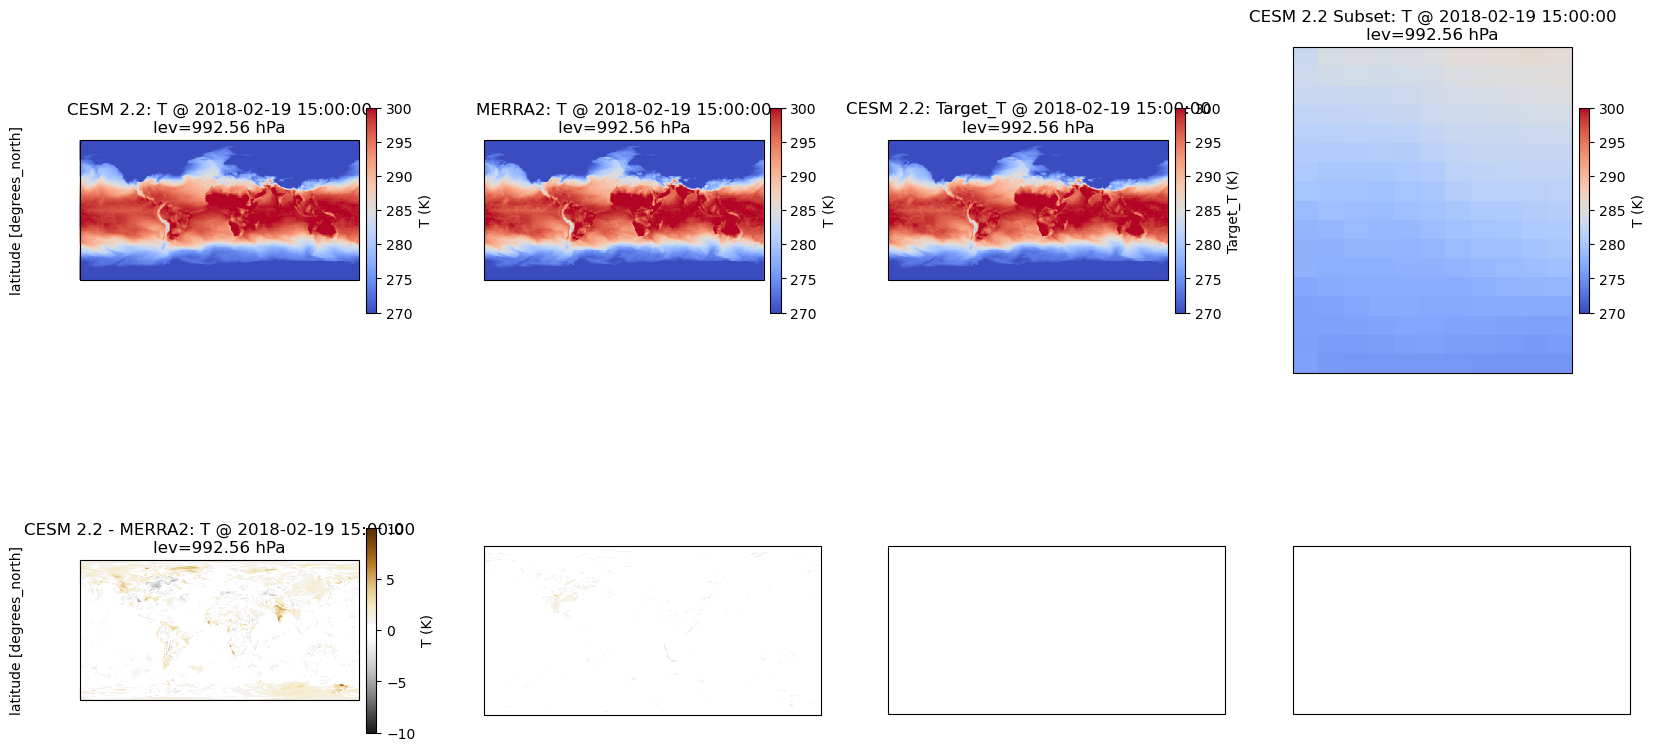

In [47]:
# Loop over time and lev indices
time_indices = range(len(h1a_ds['time'])) if 'time' in h1a_ds.dims else [None]
lev_indices = range(len(h1a_ds['lev'])) if 'lev' in h1a_ds.dims else [None]

if 1==1:
    #lev_r = np.round(h1a_ds['lev'].values[-1],2)
    var_name = "T"
    shrink = 0.585
    pad = 0.02
    #time_idx = 5
    lev_val = np.round(h1a_ds[var_name].sel(lev=992,method='nearest').lev.values,2)
    lev_unit = h1a_ds.lev.units
    #extent = [130, 165, -35, -65]  # adjust as needed
    extent = [115, 180, -20, -80]
    # Lat/lon detection
    lat_name = next((dim for dim in merra_ds.dims if 'lat' in dim.lower()), None)
    lon_name = next((dim for dim in merra_ds.dims if 'lon' in dim.lower()), None)
    nudge_lon_min = h0a_ds.lon.min().values
    nudge_lon_max = h0a_ds.lon.max().values
    nudge_lat_max = h0a_ds.lat.max().values
    nudge_lat_min = h0a_ds.lat.min().values

    lat_min, lat_max = nudge_lat_min, nudge_lat_max
    lon_min, lon_max = nudge_lon_min, nudge_lon_max

    def plot_map_multi_var_new(target_time, lev):
        coords = {}
        if lat_name and lon_name and merra_ds[lat_name].ndim == 2:
            coords['x'] = merra_ds[lon_name]
            coords['y'] = merra_ds[lat_name]
        """
        #target_time = cftime.DatetimeNoLeap(2018, 2, 5, 9, 0, 0)
        merra_ds_sfc = merra_ds[var_name].sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_ds_sfc = h1a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h0a_ds_sfc = h0a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        #print("merra",merra_ds_sfc['time'].values)
        #print("cam",h1a_ds_sfc['time'].values,"\n")
        """
        """
        do_it = True
        if all([has_time(merra_ds[var_name], target_time),
                has_time(h1a_ds.T, target_time),
                has_time(h1a_ds.Target_T, target_time),
                has_time(h1a_ds.Nudge_T, target_time),
                has_time(h0a_ds.T, target_time)
                ]):
            #target_time = cftime.DatetimeNoLeap(2018, 2, 5, 3, 0, 0)
            target_time_merra = np.datetime64(f'{target_time.year}-{target_time.month:02}-{target_time.day:02}T{target_time.hour:02}:00:00.000000000')
            merra_ds_sfc = merra_ds[var_name].sel(lev=992,method='nearest').sel(time=target_time_merra,method='nearest')
            #merra_ds_sfc = merra_ds[var_name].sel(lev=lev, method='nearest').sel(time=target_time)
            h1a_ds_sfc = h1a_ds.T.sel(lev=lev, method='nearest').sel(time=target_time)
            h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev, method='nearest').sel(time=target_time)
            h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev, method='nearest').sel(time=target_time)
            h0a_ds_sfc = h0a_ds.T.sel(lev=lev, method='nearest').sel(time=target_time)
        else:
            #pass  # Or handle missing time gracefully
            do_it = False
        """


        #target_time_merra = np.datetime64(f'{target_time.year}-{target_time.month:02}-{target_time.day:02}T{target_time.hour:02}:00:00.000000000')
        merra_ds_sfc = merra_ds[var_name].sel(lev=992,method='nearest').sel(time=target_time)
        #merra_ds_sfc = merra_ds[var_name].sel(lev=lev, method='nearest').sel(time=target_time)
        h1a_ds_sfc = h1a_ds.T.sel(lev=lev, method='nearest').sel(time=target_time)
        h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev, method='nearest').sel(time=target_time)
        h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev, method='nearest').sel(time=target_time)
        h0a_ds_sfc = h0a_ds.T.sel(lev=lev, method='nearest').sel(time=target_time)

        # Filename
        prod = "multi"
        output_dir = Path(f"plots/{case_name}/{prod}/")
        if not output_dir.is_dir():
            output_dir.mkdir(parents=True)
        #time_part = f"{time_indices[time_idx]}" if time_idx is not None else "notime"
        time_part = target_time.strftime("%Y_%m_%d_%H:00")
        #lev_part = f"_lev{lev_idx}" if lev_idx is not None else "_nolev"
        filename = f"{time_part}_{lev}hPa.png"
        filepath = os.path.join(output_dir, filename)
        
        if not os.path.exists(filepath):
            print(f"Saved plot: {filepath}")
            do_it = True
        else:
            print(f"Skipped (already exists): {filepath}")
            do_it = False

        if do_it:
            #if merra_ds_sfc['time'].values != h1a_ds_sfc['time'].values:
            #    pass
            
            # === Plotting ===
            fig, axes = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
            # Remove y-axis labels/ticks for all but first subplot
            axes[1,0].set_ylabel("Latitude", labelpad=40)
            axes[1,0].set_yticklabels([])
            axes[1,0].set_yticks([])
        
            axes[0,0].set_ylabel("Latitude", labelpad=40)
            axes[0,0].set_yticklabels([])
            axes[0,0].set_yticks([])
        
            #h0a_ds.T.sel(lev=992,method='nearest').sel(time=target_time,method='nearest')
        
        
            c0cm = h1a_ds_sfc.plot.pcolormesh(
                ax=axes[0,0],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[0,0].set_title(f"CESM 2.2: {var_name} @ {str(h1a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[0,0].figure.colorbar(c0cm, ax=axes[0,0], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} ({h1a_ds.T.attrs.get('units', '')})")
        
            mcm = merra_ds_sfc.plot.pcolormesh(
                ax=axes[0,1],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[0,1].set_title(f"MERRA2: {var_name} @ {str(merra_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[0,1].figure.colorbar(mcm, ax=axes[0,1], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} ({merra_ds.T.attrs.get('units', '')})")
        
            c0cm_target = h1a_target_ds_sfc.plot.pcolormesh(
                ax=axes[0,2],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[0,2].set_title(f"CESM 2.2: Target_{var_name} @ {str(h1a_target_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[0,2].figure.colorbar(c0cm_target, ax=axes[0,2], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"Target_{var_name} ({h1a_target_ds_sfc.attrs.get('units', '')})")
        
            dcm = (h0a_ds_sfc).plot.pcolormesh(
                    ax=axes[0,3],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm", #"PuOr",
                    vmin=270,
                    vmax=300,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            
            # Draw the giant "X" across the current extent
            #axes[0,3].plot([lon_min, lon_max], [lat_min, lat_max], color='red', linewidth=2, transform=ccrs.PlateCarree())
            #axes[0,3].plot([lon_min, lon_max], [lat_max, lat_min], color='red', linewidth=2, transform=ccrs.PlateCarree())
        
        
            axes[0,3].set_title(f"CESM 2.2 Subset: {var_name} @ {str(h0a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[0,3].figure.colorbar(dcm, ax=axes[0,3], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} ({h0a_ds_sfc.T.attrs.get('units', '')})")
        
        
        
            # ROW 2
            #-------------------
            
                
            dcm = (merra_ds_sfc-h1a_ds_sfc).plot.pcolormesh(
                    ax=axes[1,0],
                    transform=ccrs.PlateCarree(),
                    cmap="BrGy_r", #"PuOr",
                    vmin=-10,
                    vmax=10,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            axes[1,0].set_title(f"CESM 2.2 - MERRA2: {var_name} @ {str(h1a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[1,0].figure.colorbar(dcm, ax=axes[1,0], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} ({merra_ds.T.attrs.get('units', '')})")
        
        
        
            d_target_cm = (h1a_target_ds_sfc-merra_ds_sfc).plot.pcolormesh(
                    ax=axes[1,1],
                    transform=ccrs.PlateCarree(),
                    cmap="BrGy_r",
                    vmin=-10,
                    vmax=10,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            axes[1,1].set_title(f"CESM 2.2 Target - MERRA2: {var_name} @ {str(h1a_target_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[1,1].figure.colorbar(d_target_cm, ax=axes[1,1], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"Target_{var_name} ({h1a_target_ds_sfc.attrs.get('units', '')})")
        
            h1a_nudge_ds_sfc
            subset = h1a_nudge_ds_sfc.sel({lat_name: slice(lat_min, lat_max), lon_name: slice(lon_min, lon_max)})
            nudgecm = subset.plot.pcolormesh(
                    ax=axes[1,2],
                    transform=ccrs.PlateCarree(),
                    cmap="pink",
                    #vmin=-10,
                    #vmax=10,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            axes[1,2].set_title(f"CESM 2.2: Nudge_{var_name} @ {str(h1a_nudge_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[1,2].figure.colorbar(nudgecm, ax=axes[1,2], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"Nudge_{var_name} ({h1a_nudge_ds_sfc.attrs.get('units', '')})")
            # Force scientific formatting on the ticks
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar.ax.yaxis.set_major_formatter(formatter)
            cbar.update_ticks()
                
            # Determine multiplier for custom scaling
            sci_mult_str = get_scientific_multiplier(h1a_nudge_ds_sfc.values.max())  # e.g., "e14"
            sci_mult = float(f"1{get_scientific_multiplier(h1a_nudge_ds_sfc.values.max())}")  # e.g., 1e14
                
            # Scale the tick positions (numerically)
            original_ticks = cbar.get_ticks()
            scaled_ticks = [tick / sci_mult for tick in original_ticks]
                
            # Set the scaled tick positions and labels
            cbar.set_ticks(original_ticks)
            print([f"{t:.2f}" for t in scaled_ticks])
            cbar.set_ticklabels([f"{t:.2f}" for t in scaled_ticks])
                
            # Hide default offset and show multiplier as title
            sci_label = cbar.ax.yaxis.get_offset_text()
            sci_label.set_visible(False)
            cbar.ax.set_title(f'1{sci_mult_str}', fontsize=10, loc='center')
        
            
            c0cm_diff = (h1a_ds_sfc-h1a_target_ds_sfc).plot.pcolormesh(
                ax=axes[1,3],
                transform=ccrs.PlateCarree(),
                cmap="BrGy_r",
                vmin=-10,
                vmax=10,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[1,3].set_title(f"CESM 2.2: {var_name} - Target_{var_name} @ {str(h1a_target_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[1,3].figure.colorbar(c0cm_diff, ax=axes[1,3], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} - Target_{var_name} ({h1a_target_ds_sfc.attrs.get('units', '')})")
        
        
            
        
            # Flatten the 2D array of axes for easy iteration
            for ax in axes.flat:
                ax.set_extent(extent, crs=ccrs.PlateCarree())
                ax.add_feature(cfeature.LAND, zorder=0)
                ax.add_feature(cfeature.COASTLINE)
                gl = ax.gridlines(draw_labels=True)
                gl.right_labels = False
                gl.top_labels = False
                # 147e_to_161e_42s_to_58s
                nudge_lon_min = h0a_ds_sfc.lon.min().values
                nudge_lon_max = h0a_ds_sfc.lon.max().values
                nudge_lat_max = h0a_ds_sfc.lat.max().values
                nudge_lat_min = h0a_ds_sfc.lat.min().values
                #h0a_ds_sfc.lon.max().values,h0a_ds_sfc.lon.min().values
                #h0a_ds_sfc.lat.max().values,h0a_ds_sfc.lat.min().values
                # Create a rectangle (the box)
                box = Rectangle((nudge_lon_min, nudge_lat_min),  # lower-left corner
                                nudge_lon_max - nudge_lon_min,   # width
                                nudge_lat_max - nudge_lat_min,   # height
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none',
                                transform=ccrs.PlateCarree())  # Important: use map projection
                
                # Add the box to the map
                ax.add_patch(box)
        
            plt.tight_layout()
            #plt.show()
            fig.savefig(filepath, dpi=150)

            plt.close(fig)
    


for time in h1a_ds['time'].values:
    plot_map_multi_var_new(time, lev=992)
    #for lev_idx in lev_indices:
        #plot_map_multi_var(my_vars, time_idx, -1)

print(f"Product {prod} all finished!")

In [ ]:
plot_type = "multi"
slider(case_name, image_dir=f"plots/{case_name}/{prod}/")

In [ ]:
import imageio
import os
import glob
from IPython.display import Video

In [ ]:

# Get all image filenames in sorted order
image_files = sorted(glob.glob(os.path.join(output_dir, "*.png")))

# Read all frames
frames = [imageio.imread(f) for f in image_files]

# Save to MP4 with the correct writer
output_mp4 = f"{output_dir} / multi_T.mp4"
imageio.mimsave(output_mp4, frames, fps=3, format='ffmpeg')  # 'format=ffmpeg' is essential

print(f"MP4 video saved as {output_mp4}")

Video(output_mp4, embed=True, width=1200, height=500)


In [ ]:
# Loop over time and lev indices
time_indices = range(len(h1a_ds['time'])) if 'time' in h1a_ds.dims else [None]
lev_indices = range(len(h1a_ds['lev'])) if 'lev' in h1a_ds.dims else [None]

if 1==1:
    lev_r = np.round(h1a_ds['lev'].values[-1],2)
    var_name = "T"
    shrink = 0.625
    pad = 0.02
    time_idx = 5
    lev_val = np.round(h1a_ds[var_name].sel(lev=992,method='nearest').lev.values,2)
    lev_unit = h1a_ds.lev.units
    extent = [115, 180, -20, -80]  # adjust as needed
    # Lat/lon detection
    lat_name = next((dim for dim in merra_ds.dims if 'lat' in dim.lower()), None)
    lon_name = next((dim for dim in merra_ds.dims if 'lon' in dim.lower()), None)
    nudge_lon_min = h0a_ds.lon.min().values
    nudge_lon_max = h0a_ds.lon.max().values
    nudge_lat_max = h0a_ds.lat.max().values
    nudge_lat_min = h0a_ds.lat.min().values

    lat_min, lat_max = nudge_lat_min, nudge_lat_max
    lon_min, lon_max = nudge_lon_min, nudge_lon_max

    def plot_map_multi_var_new(target_time, lev):
        output_dir = Path(f"plots/{case_name}/target_minus_merra/")
        if not output_dir.is_dir():
            output_dir.mkdir(parents=True)
        time_part = target_time.strftime("%Y_%m_%d_%H:00")
        #lev_part = f"_lev{lev_idx}" if lev_idx is not None else "_nolev"
        filename = f"{time_part}_{lev}hPa.png"
        filepath = os.path.join(output_dir, filename)

        if not os.path.exists(filepath):
            #fig.savefig(filepath, dpi=150)
            print(f"Saved plot: {filepath}")
        else:
            print(f"Skipped (already exists): {filepath}")
            return
        coords = {}
        if lat_name and lon_name and merra_ds[lat_name].ndim == 2:
            coords['x'] = merra_ds[lon_name]
            coords['y'] = merra_ds[lat_name]
        """
        #target_time = cftime.DatetimeNoLeap(2018, 2, 5, 9, 0, 0)
        merra_ds_sfc = merra_ds[var_name].sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_ds_sfc = h1a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h0a_ds_sfc = h0a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        #print("merra",merra_ds_sfc['time'].values)
        #print("cam",h1a_ds_sfc['time'].values,"\n")
        """
        """
        do_it = True
        if all([has_time(merra_ds[var_name], target_time),
                has_time(h1a_ds.T, target_time),
                has_time(h1a_ds.Target_T, target_time),
                has_time(h1a_ds.Nudge_T, target_time),
                has_time(h0a_ds.T, target_time)
                ]):
            #target_time = cftime.DatetimeNoLeap(2018, 2, 5, 3, 0, 0)
            target_time_merra = np.datetime64(f'{target_time.year}-{target_time.month:02}-{target_time.day:02}T{target_time.hour:02}:00:00.000000000')
            merra_ds_sfc = merra_ds[var_name].sel(lev=992,method='nearest').sel(time=target_time_merra,method='nearest')
            #merra_ds_sfc = merra_ds[var_name].sel(lev=lev, method='nearest').sel(time=target_time)
            h1a_ds_sfc = h1a_ds.T.sel(lev=lev, method='nearest').sel(time=target_time)
            h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev, method='nearest').sel(time=target_time)
            h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev, method='nearest').sel(time=target_time)
            h0a_ds_sfc = h0a_ds.T.sel(lev=lev, method='nearest').sel(time=target_time)
        else:
            #pass  # Or handle missing time gracefully
            do_it = False
        """


        merra_ds_sfc = merra_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_ds_sfc = h1a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h0a_ds_sfc = h0a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        do_it = True

        if do_it:
            #if merra_ds_sfc['time'].values != h1a_ds_sfc['time'].values:
            #    pass
            
            # === Plotting ===
            fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
        
            # Remove y-axis labels/ticks for all but first subplot
            #axes[1,0].set_ylabel("Latitude", labelpad=40)
            #axes[1,0].set_yticklabels([])
            #axes[1,0].set_yticks([])
        
            axes[0].set_ylabel("Latitude", labelpad=40)
            axes[0].set_yticklabels([])
            axes[0].set_yticks([])
        
            #h0a_ds.T.sel(lev=992,method='nearest').sel(time=target_time,method='nearest')
        
        
            c0cm = h1a_target_ds_sfc.plot.pcolormesh(
                ax=axes[0],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[0].set_title(f"CESM: Target_{var_name} @ {str(h1a_target_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[0].figure.colorbar(c0cm, ax=axes[0], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({h1a_ds.T.attrs.get('units', '')})")
        
            mcm = merra_ds_sfc.plot.pcolormesh(
                ax=axes[1],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[1].set_title(f"MERRA2: {var_name} @ {str(merra_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[1].figure.colorbar(mcm, ax=axes[1], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({merra_ds.T.attrs.get('units', '')})")

            diff = h1a_target_ds_sfc - merra_ds_sfc
            c0cm_target = diff.plot.pcolormesh(
                ax=axes[2],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=-10,
                vmax=10,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[2].set_title(f"CESM Target_{var_name} minus MERRA2 {var_name}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[2].figure.colorbar(c0cm_target, ax=axes[2], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({h1a_target_ds_sfc.attrs.get('units', '')})")
        
            
            
            """
            dcm = (h0a_ds_sfc).plot.pcolormesh(
                    ax=axes[0,3],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm", #"PuOr",
                    vmin=270,
                    vmax=300,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            
            # Draw the giant "X" across the current extent
            #axes[0,3].plot([lon_min, lon_max], [lat_min, lat_max], color='red', linewidth=2, transform=ccrs.PlateCarree())
            #axes[0,3].plot([lon_min, lon_max], [lat_max, lat_min], color='red', linewidth=2, transform=ccrs.PlateCarree())
        
        
            axes[0,3].set_title(f"CESM 2.2 Subset: {var_name} @ {str(h0a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[0,3].figure.colorbar(dcm, ax=axes[0,3], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} ({h0a_ds_sfc.T.attrs.get('units', '')})")
        
        
        
            # ROW 2
            #-------------------
            
                
            dcm = (merra_ds_sfc-h1a_ds_sfc).plot.pcolormesh(
                    ax=axes[1,0],
                    transform=ccrs.PlateCarree(),
                    cmap="BrGy_r", #"PuOr",
                    vmin=-10,
                    vmax=10,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            axes[1,0].set_title(f"CESM 2.2 - MERRA2: {var_name} @ {str(h1a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[1,0].figure.colorbar(dcm, ax=axes[1,0], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} ({merra_ds.T.attrs.get('units', '')})")
        
        
        
            d_target_cm = (h1a_target_ds_sfc-merra_ds_sfc).plot.pcolormesh(
                    ax=axes[1,1],
                    transform=ccrs.PlateCarree(),
                    cmap="BrGy_r",
                    vmin=-10,
                    vmax=10,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            axes[1,1].set_title(f"CESM 2.2 Target - MERRA2: {var_name} @ {str(h1a_target_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[1,1].figure.colorbar(d_target_cm, ax=axes[1,1], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"Target_{var_name} ({h1a_target_ds_sfc.attrs.get('units', '')})")
        
            h1a_nudge_ds_sfc
            subset = h1a_nudge_ds_sfc.sel({lat_name: slice(lat_min, lat_max), lon_name: slice(lon_min, lon_max)})
            nudgecm = subset.plot.pcolormesh(
                    ax=axes[1,2],
                    transform=ccrs.PlateCarree(),
                    cmap="pink",
                    #vmin=-10,
                    #vmax=10,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
            axes[1,2].set_title(f"CESM 2.2: Nudge_{var_name} @ {str(h1a_nudge_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[1,2].figure.colorbar(nudgecm, ax=axes[1,2], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"Nudge_{var_name} ({h1a_nudge_ds_sfc.attrs.get('units', '')})")
            # Force scientific formatting on the ticks
            formatter = ticker.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((0, 0))
            cbar.ax.yaxis.set_major_formatter(formatter)
            cbar.update_ticks()
                
            # Determine multiplier for custom scaling
            sci_mult_str = get_scientific_multiplier(h1a_nudge_ds_sfc.values.max())  # e.g., "e14"
            sci_mult = float(f"1{get_scientific_multiplier(h1a_nudge_ds_sfc.values.max())}")  # e.g., 1e14
                
            # Scale the tick positions (numerically)
            original_ticks = cbar.get_ticks()
            scaled_ticks = [tick / sci_mult for tick in original_ticks]
                
            # Set the scaled tick positions and labels
            cbar.set_ticks(original_ticks)
            print([f"{t:.2f}" for t in scaled_ticks])
            cbar.set_ticklabels([f"{t:.2f}" for t in scaled_ticks])
                
            # Hide default offset and show multiplier as title
            sci_label = cbar.ax.yaxis.get_offset_text()
            sci_label.set_visible(False)
            cbar.ax.set_title(f'1{sci_mult_str}', fontsize=10, loc='center')
        
            
            c0cm_diff = (h1a_ds_sfc-h1a_target_ds_sfc).plot.pcolormesh(
                ax=axes[1,3],
                transform=ccrs.PlateCarree(),
                cmap="BrGy_r",
                vmin=-10,
                vmax=10,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[1,3].set_title(f"CESM 2.2: {var_name} - Target_{var_name} @ {str(h1a_target_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[1,3].figure.colorbar(c0cm_diff, ax=axes[1,3], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"{var_name} - Target_{var_name} ({h1a_target_ds_sfc.attrs.get('units', '')})")
        
        
            """
        
            # Flatten the 2D array of axes for easy iteration
            #for ax in axes.flat:
            for ax in axes:
                ax.set_extent(extent, crs=ccrs.PlateCarree())
                ax.add_feature(cfeature.LAND, zorder=0)
                ax.add_feature(cfeature.COASTLINE)
                gl = ax.gridlines(draw_labels=True)
                gl.right_labels = False
                gl.top_labels = False
                # 147e_to_161e_42s_to_58s
                nudge_lon_min = h0a_ds_sfc.lon.min().values
                nudge_lon_max = h0a_ds_sfc.lon.max().values
                nudge_lat_max = h0a_ds_sfc.lat.max().values
                nudge_lat_min = h0a_ds_sfc.lat.min().values
                #h0a_ds_sfc.lon.max().values,h0a_ds_sfc.lon.min().values
                #h0a_ds_sfc.lat.max().values,h0a_ds_sfc.lat.min().values
                # Create a rectangle (the box)
                box = Rectangle((nudge_lon_min, nudge_lat_min),  # lower-left corner
                                nudge_lon_max - nudge_lon_min,   # width
                                nudge_lat_max - nudge_lat_min,   # height
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none',
                                transform=ccrs.PlateCarree())  # Important: use map projection
                
                # Add the box to the map
                ax.add_patch(box)
        
            plt.tight_layout()
            #plt.show()
            fig.savefig(filepath, dpi=150)
            """
            # Filename
            output_dir = Path(f"plots/{case_name}/target_minus_merra/")
            if not output_dir.is_dir():
                output_dir.mkdir(parents=True)
            #time_part = f"{time_indices[time_idx]}" if time_idx is not None else "notime"
            time_part = target_time.strftime("%Y_%m_%d_%H:00")
            #lev_part = f"_lev{lev_idx}" if lev_idx is not None else "_nolev"
            filename = f"{time_part}_{lev_r}hPa.png"
            filepath = os.path.join(output_dir, filename)
        
            if not os.path.exists(filepath):
                fig.savefig(filepath, dpi=150)
                print(f"Saved plot: {filepath}")
            else:
                print(f"Skipped (already exists): {filepath}")
            """
            plt.close(fig)
    


for time in h1a_ds['time'].values:
    plot_map_multi_var_new(time, lev=lev_r)
    #for lev_idx in lev_indices:
        #plot_map_multi_var(my_vars, time_idx, -1)

In [52]:
#h2i_ds['time'].values
h0a_init_ds['time'].values

array([cftime.DatetimeNoLeap(2018, 2, 19, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 21, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 21, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [ ]:
h2i_ds.sel(lev=slice(700,1000))['lev'].values

In [55]:
case_name = exp_casenames[4]
print(case_name)
casenl_path = f"/glade/derecho/scratch/richling/cases/{case_name}/user_nl_cam"
h0a_ds, h1a_ds, h2i_ds = get_cam_ds(casenl_path)
h0a_ds.time.values

F2000climo.f09_f09_mg17.window.exp.48hrInit.R13.002
fincl1lonlat = '147e:161e_42s:58s'
147e_to_161e_42s_to_58s
('147e:161e', '_', '42s:58s')
147e_to_161e     42s_to_58s
All done


array([cftime.DatetimeNoLeap(2018, 2, 18, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 18, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 18, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 18, 21, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 21, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 21, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [58]:
h2i_ds.time.values

array([cftime.DatetimeNoLeap(2018, 2, 19, 6, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 19, 18, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 6, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 20, 18, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 2, 21, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [59]:
# --- Settings dropdowns ---
if 1==1:
    def load_user_nl(case_path):
        lines = []
        lines_all = []
        try:
            with open(f"{case_path}/user_nl_cam", 'r') as file:
                for line in file:
                    if line.startswith(' Nudge_'):
                        lines.append(line.strip())
                    if line.startswith(' '):
                        lines_all.append(line.strip())
        except Exception as e:
            lines = [f"Error reading user_nl_cam: {e}"]
            lines_all = lines
        return "\n".join(lines), "\n".join(lines_all)
    
    def load_case_status(case_path):
        lines = []
        try:
            with open(f"{case_path}/CaseStatus", 'r') as file:
                lines = [line.strip() for line in file]
        except Exception as e:
            lines = [f"Error reading CaseStatus: {e}"]
        return "\n".join(lines)

case_path = f"/glade/derecho/scratch/richling/{init_casenl_name}"
nudge_text, full_text = load_user_nl(case_path)
status_text = load_case_status(case_path)

In [68]:
#settings_output = widgets.Output()
#with settings_output:
from IPython.display import display, HTML
#case_path = f"/glade/derecho/scratch/richling/{init_casenl_name}"



case_name = exp_casenames[3]
print(case_name)
case_path = f"/glade/derecho/scratch/richling/cases/{case_name}/"

nudge_text, full_text = load_user_nl(case_path)
status_text = load_case_status(case_path)
display(HTML("<pre>" + full_text + "</pre>")),display(HTML("<pre>" + status_text + "</pre>"))

F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002


(None, None)

In [56]:
init_casenl_name = "nudged-socrates-inithist-004-window"
init_casenl_path = f"/glade/derecho/scratch/richling/{init_casenl_name}/user_nl_cam"
h0a_init_ds, h1a_init_ds, h2i_init_ds = get_cam_ds(init_casenl_path)

case_name = exp_casenames[3]
print(case_name)
casenl_path = f"/glade/derecho/scratch/richling/cases/{case_name}/user_nl_cam"
h0a_ds, h1a_ds, h2i_ds = get_cam_ds(casenl_path)


# Loop over time and lev indices
time_indices = range(len(h2i_ds['time'])) if 'time' in h2i_ds.dims else [None]
lev_indices = range(len(h2i_ds['lev'])) if 'lev' in h2i_ds.dims else [None]

#case_name = "nudged-socrates-inithist-002-window"  # Change this to your case
#image_dir = Path(f"plots/{case_name}/MERRA_T_minus_T/")


if 1==1:
    #lev_r = int(h2i_ds['lev'].values[-1])
    var_name = "T"
    var_names = ["T","Q"]
    var_names = ["Q"]
    shrink = 0.625
    pad = 0.02
    #time_idx = 5

    lev_unit = h2i_ds.lev.units
    extent = [120, 175, -25, -75]  # adjust as needed
    # Lat/lon detection
    lat_name = next((dim for dim in h2i_init_ds.dims if 'lat' in dim.lower()), None)
    lon_name = next((dim for dim in h2i_init_ds.dims if 'lon' in dim.lower()), None)
    lat_min, lat_max = -65, -35
    lon_min, lon_max = 130, 165

    minmax_dict = {763:[235,295],
                  820:[225,300],
                  976:[230,310]}

    def plot_map_multi_var_new(var_name, target_time, lev):

        image_dir = Path(f"plots/{case_name}_vs_init_case/{var_name}/")
        if not image_dir.is_dir():
            image_dir.mkdir(parents=True)
                
        coords = {}
        if lat_name and lon_name and h2i_init_ds[lat_name].ndim == 2:
            coords['x'] = h2i_init_ds[lon_name]
            coords['y'] = h2i_init_ds[lat_name]


        h2i_init_ds_sfc = h2i_init_ds[var_name].sel(lev=lev,method='nearest').sel(time=target_time)
        h2i_ds_sfc = h2i_ds[var_name].sel(lev=lev,method='nearest').sel(time=target_time)
        h0a_ds_sfc = h0a_ds[var_name].sel(lev=lev,method='nearest').sel(time=target_time)
        #h1a_target_ds_sfc = h2i_ds.Target_T.sel(lev=lev,method='nearest').sel(time=target_time)
        #h1a_nudge_ds_sfc = h2i_ds.Nudge_T.sel(lev=lev,method='nearest').sel(time=target_time)
        #h0a_ds_sfc = h0a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)

        #time_part = f"{time_indices[time_idx]}" if time_idx is not None else "notime"
        time_part = target_time.strftime("%Y_%m_%d_%H:00")
        #lev_part = f"_lev{lev_idx}" if lev_idx is not None else "_nolev"
        lev_r = int(lev)
        filename = f"{time_part}_{lev_r}hPa.png"
        filepath = os.path.join(image_dir, filename)
        
        if not os.path.exists(filepath):
            print(f"Saved plot: {filepath}")
            do_it = True
        else:
            print(f"Skipped (already exists): {filepath}")
            do_it = False

        
        

        if do_it:
            #if merra_ds_sfc['time'].values != h1a_ds_sfc['time'].values:
            #    pass
            
            # === Plotting ===
            fig, axes = plt.subplots(1, 4, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
        
            # Remove y-axis labels/ticks for all but first subplot
            #axes[1,0].set_ylabel("Latitude", labelpad=40)
            #axes[1,0].set_yticklabels([])
            #axes[1,0].set_yticks([])
        
            axes[0].set_ylabel("Latitude", labelpad=40)
            axes[0].set_yticklabels([])
            axes[0].set_yticks([])
        
            #h0a_ds.T.sel(lev=992,method='nearest').sel(time=target_time,method='nearest')

            #if lev_r in minmax_dict:
            if 2==1:
                #min = minmax_dict[lev_r][0]
                #max = minmax_dict[lev_r][-1]
        
                c0cm = h2i_init_ds_sfc.plot.pcolormesh(
                    ax=axes[0],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm",
                    #vmin=min,
                    #vmax=max,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
                axes[0].set_title(f"CESM Init: {var_name} @ {str(h2i_init_ds_sfc['time'].values)}\nlev={lev_r} {lev_unit}")
                cbar = axes[0].figure.colorbar(c0cm, ax=axes[0], orientation='vertical', shrink=shrink, pad=pad)
                cbar.set_label(f"({h2i_init_ds.T.attrs.get('units', '')})")
    
                mcm = h2i_ds_sfc.plot.pcolormesh(
                    ax=axes[1],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm",
                    #vmin=min,
                    #vmax=max,
                    #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
                axes[1].set_title(f"CESM: {var_name} @ {str(time_part)}\nlev={lev_r} {lev_unit}")
                # Custom colorbar matching height of axes
                cbar = axes[1].figure.colorbar(mcm, ax=axes[1], orientation='vertical', shrink=shrink, pad=pad)
            else:
                if var_name == "T":
                    min = 220
                    max = 310
                if var_name == "Q":
                    min = 0
                    max = 0.018
                c0cm = h2i_init_ds_sfc.plot.pcolormesh(
                    ax=axes[0],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm",
                    vmin=min,
                    vmax=max,
                    #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
                axes[0].set_title(f"CESM Init: {var_name} @ {str(h2i_init_ds_sfc['time'].values)}\nlev={lev_r} {lev_unit}")
                cbar = axes[0].figure.colorbar(c0cm, ax=axes[0], orientation='vertical', shrink=shrink, pad=pad)
                cbar.set_label(f"({h2i_init_ds.T.attrs.get('units', '')})")
        
                mcm = h2i_ds_sfc.plot.pcolormesh(
                    ax=axes[1],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm",
                    vmin=min,
                    vmax=max,
                    #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
                axes[1].set_title(f"CESM: {var_name} @ {str(time_part)}\nlev={lev_r} {lev_unit}")
                # Custom colorbar matching height of axes
                cbar = axes[1].figure.colorbar(mcm, ax=axes[1], orientation='vertical', shrink=shrink, pad=pad)

                subset = h0a_ds_sfc.plot.pcolormesh(
                    ax=axes[3],
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm",
                    vmin=min,
                    vmax=max,
                    #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                    add_colorbar=False,  # We'll add manually
                    **coords
                )
                axes[3].set_title(f"CESM Subset: {var_name} @ {str(time_part)}\nlev={lev_r} {lev_unit}")
                # Custom colorbar matching height of axes
                cbar = axes[3].figure.colorbar(subset, ax=axes[3], orientation='vertical', shrink=shrink, pad=pad)
            
            cbar.set_label(f"({h0a_ds.T.attrs.get('units', '')})")

            diff = h2i_init_ds_sfc - h2i_ds_sfc
            c0cm_target = diff.plot.pcolormesh(
                ax=axes[2],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=-10,
                vmax=10,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[2].set_title(f"CESM Init minus CESM - {var_name} @ {str(time_part)}\nlev={lev_r} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[2].figure.colorbar(c0cm_target, ax=axes[2], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({h2i_ds.T.attrs.get('units', '')})")

            # Flatten the 2D array of axes for easy iteration
            #for ax in axes.flat:
            for ax in axes:
                ax.set_extent(extent, crs=ccrs.PlateCarree())
                ax.add_feature(cfeature.LAND, zorder=0)
                ax.add_feature(cfeature.COASTLINE)
                gl = ax.gridlines(draw_labels=True)
                gl.right_labels = False
                gl.top_labels = False
                # 147e_to_161e_42s_to_58s
                nudge_lon_min = 130 #h0a_ds_sfc.lon.min().values
                nudge_lon_max = 160 #h0a_ds_sfc.lon.max().values
                nudge_lat_max = -35 #h0a_ds_sfc.lat.max().values
                nudge_lat_min = -65 #h0a_ds_sfc.lat.min().values
                #h0a_ds_sfc.lon.max().values,h0a_ds_sfc.lon.min().values
                #h0a_ds_sfc.lat.max().values,h0a_ds_sfc.lat.min().values
                # Create a rectangle (the box)
                box = Rectangle((nudge_lon_min, nudge_lat_min),  # lower-left corner
                                nudge_lon_max - nudge_lon_min,   # width
                                nudge_lat_max - nudge_lat_min,   # height
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none',
                                transform=ccrs.PlateCarree())  # Important: use map projection
                
                # Add the box to the map
                ax.add_patch(box)
        
            plt.tight_layout()
            fig.savefig(filepath, dpi=150)
            #plt.show()
            """
            # Filename

            #time_part = f"{time_indices[time_idx]}" if time_idx is not None else "notime"
            time_part = target_time.strftime("%Y_%m_%d_%H:00")
            #lev_part = f"_lev{lev_idx}" if lev_idx is not None else "_nolev"
            filename = f"{time_part}_{lev_r}hPa.png"
            filepath = os.path.join(image_dir, filename)
        
            if not os.path.exists(filepath):
                fig.savefig(filepath, dpi=150)
                print(f"Saved plot: {filepath}")
            else:
                print(f"Skipped (already exists): {filepath}")
            """
            plt.close(fig)
    


for time in h2i_ds['time'].values:
    for lev in h2i_ds.sel(lev=slice(700,1000))['lev'].values:
        for var in var_names:
            plot_map_multi_var_new(var, time, lev=lev)
    #for lev_idx in lev_indices:
        #plot_map_multi_var(my_vars, time_idx, -1)
print("All Done!")

fincl1lonlat = '130e:170e_40s:65s'
130e_to_170e_40s_to_65s
('130e:170e', '_', '40s:65s')
130e_to_170e     40s_to_65s
All done
F2000climo.f09_f09_mg17.window.exp.24hrInit.R13.002
fincl1lonlat = '147e:161e_42s:58s'
147e_to_161e_42s_to_58s
('147e:161e', '_', '42s:58s')
147e_to_161e     42s_to_58s
All done


KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [17]:
def slider2(case_name, image_dir_base=f"plots/{case_name}/MERRA_T_minus_T/"):
    import os
    from PIL import Image
    from io import BytesIO
    import base64
    from IPython.display import display, HTML
    import ipywidgets as widgets

    tooltip_dict = {
        "Nudge_Uprof": prof,
        "Nudge_Ucoef": coef,
        "Nudge_Hwin_lat0": Hwin_lat0,
        "Nudge_Hwin_lon0": Hwin_lon0,
        "Nudge_Hwin_latWidth": Hwin_latlonWidth,
        "Nudge_Hwin_lonWidth": Hwin_latlonWidth,
        "Nudge_Vwin_Hindex": Vwin_Hindex,
        "Nudge_Vwin_Lindex": Vwin_Lindex,
        "Nudge_Vwin_Hdelta": Vwin_LHdelta,
        "Nudge_Vwin_Ldelta": Vwin_LHdelta,
        "Nudge_Hwin_latDelta": Hwin_latlonDelta,
        "Nudge_Hwin_lonDelta": Hwin_latlonDelta,
    }

    link_dict = {
        "Nudge_Uprof": "https://ncar.github.io/CAM/doc/build/html/users_guide/physics-modifications-via-the-namelist.html?highlight=nudge#namelist-values",
    }

    def image_to_html(img):
        # img is a PIL Image already resized
        buffer = BytesIO()
        img.save(buffer, format='PNG')
        b64 = base64.b64encode(buffer.getvalue()).decode()
        return f"<img src='data:image/png;base64,{b64}' style='width:100%;'/>"

    # Discover available pressure levels
    all_files = sorted([f for f in os.listdir(image_dir_base) if f.endswith('.png')])
    import re
    levels_set = set()
    for f in all_files:
        match = re.search(r'_(\d+)hPa\.png$', f)
        if match:
            levels_set.add(int(match.group(1)))
    levels = sorted(levels_set)

    if not levels:
        print(f"No images found in {image_dir_base} matching '*hPa.png'")
        return

    level_dropdown = widgets.Dropdown(options=levels, value=levels[0], description='Level (hPa)')
    time_slider = widgets.IntSlider(min=0, max=0, step=1, description='Time Index')
    output = widgets.Output()

    # Cache: {level: [ (timestamp, html_image), ... ]}
    cached_images = {}

    def load_images_for_level(level):
        image_files = sorted([
            os.path.join(image_dir_base, f) for f in os.listdir(image_dir_base)
            if f.endswith(f'{level}hPa.png')
        ])
        timestamps = ['-'.join(os.path.basename(f).split('_')[0:3]) + ' ' + os.path.basename(f).split('_')[3] for f in image_files]

        imgs_html = []
        for img_path in image_files:
            img = Image.open(img_path).resize((1000, 300))
            imgs_html.append(image_to_html(img))
        return list(zip(timestamps, imgs_html))

    def update_display(change=None):
        level = level_dropdown.value

        if level not in cached_images:
            cached_images[level] = load_images_for_level(level)

        images = cached_images[level]

        if not images:
            with output:
                output.clear_output()
                print(f"No images found for level {level} hPa.")
            time_slider.max = 0
            return

        # Update slider max if needed
        if time_slider.max != len(images) - 1:
            time_slider.max = len(images) - 1

        timestamp, html_img = images[time_slider.value]

        with output:
            output.clear_output(wait=True)  # wait=True reduces flicker
            html_ts = f"<h3 style='text-align:center;'>{timestamp}</h3>"
            display(HTML(html_ts + html_img))

    def on_level_change(change):
        time_slider.value = 0
        update_display()

    def on_time_change(change):
        update_display()

    level_dropdown.observe(on_level_change, names='value')
    time_slider.observe(on_time_change, names='value')

    update_display()

    # The rest of your dropdown and UI layout code unchanged (copied from previous snippet)...

    def load_user_nl():
        lines = []
        lines_all = []
        try:
            with open(f"/glade/derecho/scratch/richling/cases/{case_name}/user_nl_cam", 'r') as file:
                for line in file:
                    if line.startswith(' Nudge_'):
                        lines.append(line.strip())
                    if line.startswith(' '):
                        lines_all.append(line.strip())
        except Exception as e:
            lines = [f"Error reading user_nl_cam: {e}"]
            lines_all = lines
        return "\n".join(lines), "\n".join(lines_all)

    def load_case_status():
        lines = []
        try:
            with open(f"/glade/derecho/scratch/richling/cases/{case_name}/CaseStatus", 'r') as file:
                lines = [line.strip() for line in file]
        except Exception as e:
            lines = [f"Error reading CaseStatus: {e}"]
        return "\n".join(lines)

    nudge_text, full_text = load_user_nl()
    status_text = load_case_status()

    settings_dropdown = widgets.Dropdown(options=["Hide Settings", "Nudge Params", "Full user_nl_cam"], description="Settings")
    status_dropdown = widgets.Dropdown(options=["Hide CaseStatus", "CaseStatus"], description="CaseDocs")
    settings_output = widgets.Output()
    status_output = widgets.Output()

    def update_settings(change):
        settings_output.clear_output()

        if settings_dropdown.value == "Nudge Params":
            processed_lines = []
            for line in nudge_text.splitlines():
                for key in set(link_dict.keys()).union(tooltip_dict.keys()):
                    if key in line:
                        title = tooltip_dict.get(key, "")
                        href = link_dict.get(key)
                        if href:
                            replacement = f'<a href="{href}" target="_blank" title="{title}">{key}</a>'
                        else:
                            replacement = f'<span title="{title}">{key}</span>'
                        line = line.replace(key, replacement)
                processed_lines.append(line)
            html_output = "<br>".join(processed_lines)
            with settings_output:
                display(HTML(html_output))

        elif settings_dropdown.value == "Full user_nl_cam":
            with settings_output:
                display(HTML("<pre>" + full_text + "</pre>"))

    def update_status(change):
        with status_output:
            status_output.clear_output()
            if status_dropdown.value == "CaseStatus":
                print(status_text)

    settings_dropdown.observe(update_settings, names='value')
    status_dropdown.observe(update_status, names='value')

    from ipywidgets import Layout

    settings_output.layout = Layout(margin='0 20px 0 0')
    status_output.layout = Layout(margin='0 0 0 20px')

    output_row = widgets.HBox([settings_output, status_output])
    dropdown_row = widgets.HBox([settings_dropdown, status_dropdown], layout=Layout(margin='10px 0 10px 0'))

    ui = widgets.VBox([level_dropdown, time_slider, output, dropdown_row, output_row])

    display(ui)


In [18]:
plot_type = "T"
#plot_type = "Q"
slider2(case_name, f"plots/F2000climo.f09_f09_mg17.window.exp.18hrInit.R13.002_vs_init_case/{plot_type}/")

In [ ]:
sorted(glob(f"/glade/derecho/scratch/richling/{case_name}/run/*cam.i*"))

In [ ]:
|

In [ ]:
h2i_ds

In [ ]:
h2i_init_ds

In [ ]:
if 1==1:
    var_name = "T"
    target_time = cftime.DatetimeNoLeap(2018, 2, 19, 12, 0, 0)
    shrink = 0.62
    pad = 0.02
    time_idx = 0
    lev_val = np.round(h2i_ds[var_name].sel(lev=992,method='nearest').lev.values,2)
    lev_unit = h2i_ds.lev.units
    extent = [130, 165, -35, -65]  # adjust as needed
    # Lat/lon detection
    lat_name = next((dim for dim in h2i_init_ds.dims if 'lat' in dim.lower()), None)
    lon_name = next((dim for dim in h2i_init_ds.dims if 'lon' in dim.lower()), None)

    coords = {}
    if lat_name and lon_name and h2i_init_ds[lat_name].ndim == 2:
        coords['x'] = h2i_init_ds[lon_name]
        coords['y'] = h2i_init_ds[lat_name]
    # === Plotting ===
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

    # Remove y-axis labels/ticks for all but first subplot
    axes[0].set_ylabel("Latitude", labelpad=40)
    axes[0].set_yticklabels([])
    axes[0].set_yticks([])

    #h0a_ds.T.sel(lev=992,method='nearest').sel(time=target_time,method='nearest')
    mcm = h2i_init_ds[var_name].sel(lev=992,method='nearest').sel(time=target_time).plot.pcolormesh(
        ax=axes[0],
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=270,
        vmax=300,
        #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
        add_colorbar=False,  # We'll add manually
        **coords
    )
    axes[0].set_title(f"MERRA2: {var_name} @ {str(target_time)}\nlev={lev_val} {lev_unit}")
    # Custom colorbar matching height of axes
    cbar = axes[0].figure.colorbar(mcm, ax=axes[0], orientation='vertical', shrink=shrink, pad=pad)
    cbar.set_label(f"{var_name} ({h2i_init_ds.T.attrs.get('units', '')})")

    c0cm = h2i_ds[var_name].sel(lev=992,method='nearest').isel(time=time_idx).plot.pcolormesh(
        ax=axes[1],
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=270,
        vmax=300,
        #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
        add_colorbar=False,  # We'll add manually
        **coords
    )
    axes[1].set_title(f"CESM 2.2: {var_name} @ {str(h2i_ds['time'].values[time_idx])}\nlev={lev_val} {lev_unit}")
    cbar = axes[1].figure.colorbar(c0cm, ax=axes[1], orientation='vertical', shrink=shrink, pad=pad)
    cbar.set_label(f"{var_name} ({h2i_ds.T.attrs.get('units', '')})")

    diff = (h2i_init_ds[var_name].sel(lev=992,method='nearest').sel(time=target_time)-h2i_ds[var_name].sel(lev=992,method='nearest').isel(time=time_idx))
    diff_cf = diff.plot.pcolormesh(
        ax=axes[2],
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=-10,
        vmax=10,
        #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
        add_colorbar=False,  # We'll add manually
        **coords
    )
    axes[2].set_title(f"MERRA2 - CESM 2.2: {var_name} @ {str(h2i_ds['time'].values[time_idx])}\nlev={lev_val} {lev_unit}")
    cbar = axes[2].figure.colorbar(diff_cf, ax=axes[2], orientation='vertical', shrink=shrink, pad=pad)
    cbar.set_label(f"{var_name} ({h2i_ds.T.attrs.get('units', '')})")


    for ax in axes:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, zorder=0)
        ax.add_feature(cfeature.COASTLINE)
        #ax.gridlines(draw_labels=True)
        gl = ax.gridlines(draw_labels=True)
        gl.right_labels = False
        gl.top_labels = False

    plt.tight_layout()
    plt.show()

In [ ]:
# Loop over time and lev indices
time_indices = range(len(h1a_ds['time'])) if 'time' in h1a_ds.dims else [None]
lev_indices = range(len(h1a_ds['lev'])) if 'lev' in h1a_ds.dims else [None]

#case_name = "nudged-socrates-inithist-002-window"  # Change this to your case
image_dir = Path(f"plots/{case_name}/MERRA_T_minus_T_subset/")
if not image_dir.is_dir():
    image_dir.mkdir(parents=True)

if 1==1:
    lev_r = np.round(h1a_ds['lev'].values[-1],2)
    var_name = "T"
    shrink = 0.625
    pad = 0.02
    time_idx = 5
    lev_val = np.round(h1a_ds[var_name].sel(lev=992,method='nearest').lev.values,2)
    lev_unit = h1a_ds.lev.units
    extent = [130, 165, -35, -65]  # adjust as needed
    # Lat/lon detection
    lat_name = next((dim for dim in merra_ds.dims if 'lat' in dim.lower()), None)
    lon_name = next((dim for dim in merra_ds.dims if 'lon' in dim.lower()), None)
    lat_min, lat_max = -65, -35
    lon_min, lon_max = 130, 165

    def plot_map_multi_var_new(target_time, lev):
        coords = {}
        if lat_name and lon_name and merra_ds[lat_name].ndim == 2:
            coords['x'] = merra_ds[lon_name]
            coords['y'] = merra_ds[lat_name]



        merra_ds_sfc = merra_ds.T.sel(lev=lev,method='nearest').sel(time=target_time,method='nearest')
        h1a_ds_sfc = h1a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_target_ds_sfc = h1a_ds.Target_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h1a_nudge_ds_sfc = h1a_ds.Nudge_T.sel(lev=lev,method='nearest').sel(time=target_time)
        h0a_ds_sfc = h0a_ds.T.sel(lev=lev,method='nearest').sel(time=target_time)
        #time_part = f"{time_indices[time_idx]}" if time_idx is not None else "notime"
        time_part = target_time.strftime("%Y_%m_%d_%H:00")
        #lev_part = f"_lev{lev_idx}" if lev_idx is not None else "_nolev"
        filename = f"{time_part}_{lev}hPa.png"
        filepath = os.path.join(image_dir, filename)
        
        if not os.path.exists(filepath):
            print(f"Saved plot: {filepath}")
            do_it = True
        else:
            print(f"Skipped (already exists): {filepath}")
            do_it = False

        if do_it:
            #if merra_ds_sfc['time'].values != h1a_ds_sfc['time'].values:
            #    pass
            
            # === Plotting ===
            fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})
        
            # Remove y-axis labels/ticks for all but first subplot
            #axes[1,0].set_ylabel("Latitude", labelpad=40)
            #axes[1,0].set_yticklabels([])
            #axes[1,0].set_yticks([])
        
            axes[0].set_ylabel("Latitude", labelpad=40)
            axes[0].set_yticklabels([])
            axes[0].set_yticks([])
        
            #h0a_ds.T.sel(lev=992,method='nearest').sel(time=target_time,method='nearest')
        
        
            c0cm = merra_ds_sfc.plot.pcolormesh(
                ax=axes[0],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({h0a_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[0].set_title(f"MERRA2: {var_name} @ {str(merra_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            cbar = axes[0].figure.colorbar(c0cm, ax=axes[0], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({merra_ds.T.attrs.get('units', '')})")
        
            mcm = h0a_ds_sfc.plot.pcolormesh(
                ax=axes[1],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=270,
                vmax=300,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[1].set_title(f"CESM: Subset {var_name} @ {str(h0a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[1].figure.colorbar(mcm, ax=axes[1], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({h0a_ds.T.attrs.get('units', '')})")

            diff = merra_ds_sfc - h0a_ds_sfc
            c0cm_target = diff.plot.pcolormesh(
                ax=axes[2],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=-10,
                vmax=10,
                #cbar_kwargs={'label': f"{var_name} ({merra_ds.attrs.get('units', '')})"},
                add_colorbar=False,  # We'll add manually
                **coords
            )
            axes[2].set_title(f"MERRA2 {var_name} minus CESM Subset {var_name} @ {str(h1a_ds_sfc['time'].values)}\nlev={lev_val} {lev_unit}")
            # Custom colorbar matching height of axes
            cbar = axes[2].figure.colorbar(c0cm_target, ax=axes[2], orientation='vertical', shrink=shrink, pad=pad)
            cbar.set_label(f"({h1a_ds.T.attrs.get('units', '')})")

            # Flatten the 2D array of axes for easy iteration
            #for ax in axes.flat:
            for ax in axes:
                ax.set_extent(extent, crs=ccrs.PlateCarree())
                ax.add_feature(cfeature.LAND, zorder=0)
                ax.add_feature(cfeature.COASTLINE)
                gl = ax.gridlines(draw_labels=True)
                gl.right_labels = False
                gl.top_labels = False
                # 147e_to_161e_42s_to_58s
                nudge_lon_min = h0a_ds_sfc.lon.min().values
                nudge_lon_max = h0a_ds_sfc.lon.max().values
                nudge_lat_max = h0a_ds_sfc.lat.max().values
                nudge_lat_min = h0a_ds_sfc.lat.min().values
                #h0a_ds_sfc.lon.max().values,h0a_ds_sfc.lon.min().values
                #h0a_ds_sfc.lat.max().values,h0a_ds_sfc.lat.min().values
                # Create a rectangle (the box)
                box = Rectangle((nudge_lon_min, nudge_lat_min),  # lower-left corner
                                nudge_lon_max - nudge_lon_min,   # width
                                nudge_lat_max - nudge_lat_min,   # height
                                linewidth=2,
                                edgecolor='black',
                                facecolor='none',
                                transform=ccrs.PlateCarree())  # Important: use map projection
                
                # Add the box to the map
                ax.add_patch(box)
        
            plt.tight_layout()
            #plt.show()
            # Filename
            fig.savefig(filepath, dpi=150)
            plt.close(fig)
    


for time in h1a_ds['time'].values:
    plot_map_multi_var_new(time, lev=992)
    #for lev_idx in lev_indices:
        #plot_map_multi_var(my_vars, time_idx, -1)